## Import Library

In [22]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [23]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [24]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

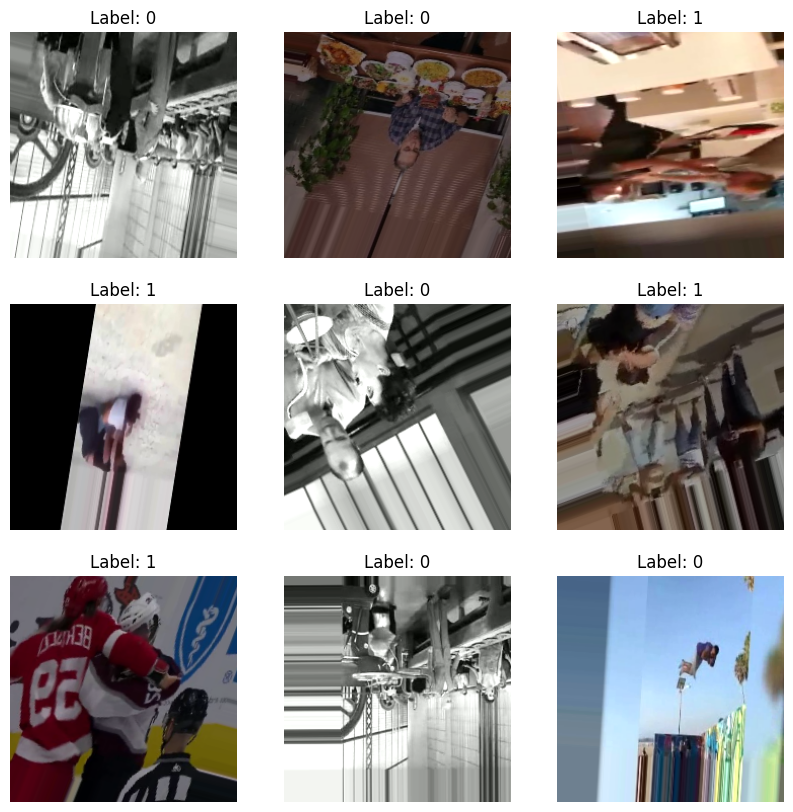

In [25]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [26]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Full Fine-Tune
for layer in base_model.layers:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_NoFreeze_0.01.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 15,110,465 (57.64 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [27]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.4568 - loss: 1.5410
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to NoMCLAHE_NoFreeze_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 86s 916ms/step - accuracy: 0.4577 - loss: 1.5386 - val_accuracy: 0.5000 - val_loss: 37169.0195
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.5295 - loss: 1.0812
Epoch 2: val_accuracy did not improve from 0.50000
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 726ms/step - accuracy: 0.5289 - loss: 1.0806 - val_accuracy: 0.5000 - val_loss: 1.1843
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.4848 - loss: 0.9416
Epoch 3: val_accuracy did not improve from 0.50000
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 701ms/step - accuracy: 0.4848 - loss: 0.9413 - val_accuracy: 0.5000 - val_loss: 0.9891
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.4902 - loss: 0.8861
Epoch 4: val_accuracy did not improve from 0.50000
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 701ms/step - accuracy: 0.4905 - loss: 0.8858 - val_accuracy: 0.5000 - val_loss: 1.4094
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.5057 - loss: 0.8530
Epoch 5: val_accuracy did n

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 712ms/step - accuracy: 0.5244 - loss: 0.9456 - val_accuracy: 0.5750 - val_loss: 0.9074
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.5810 - loss: 0.9181
Epoch 14: val_accuracy did not improve from 0.57500
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 695ms/step - accuracy: 0.5808 - loss: 0.9179 - val_accuracy: 0.5000 - val_loss: 0.9061
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.6301 - loss: 0.8743
Epoch 15: val_accuracy did not improve from 0.57500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 708ms/step - accuracy: 0.6295 - loss: 0.8746 - val_accuracy: 0.5000 - val_loss: 0.9117
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.5985 - loss: 0.8943
Epoch 16: val_accuracy did not improve from 0.57500
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 695ms/step - accuracy: 0.5984 - loss: 0.8943 - val_accuracy: 0.5273 - val_loss: 0.9087
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.5921 - loss: 0.9049
Epoch 17: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 718ms/step - accuracy: 0.6819 - loss: 0.9589 - val_accuracy: 0.6318 - val_loss: 1.0348
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.6715 - loss: 0.9939
Epoch 30: val_accuracy did not improve from 0.63182
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 696ms/step - accuracy: 0.6716 - loss: 0.9940 - val_accuracy: 0.5045 - val_loss: 1.0697
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.6839 - loss: 0.9957
Epoch 31: val_accuracy did not improve from 0.63182
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 701ms/step - accuracy: 0.6837 - loss: 0.9959 - val_accuracy: 0.5273 - val_loss: 1.0828
Epoch 32/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.6659 - loss: 1.0294
Epoch 32: val_accuracy did not improve from 0.63182
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 689ms/step - accuracy: 0.6660 - loss: 1.0299 - val_accuracy: 0.5545 - val_loss: 1.1961
Epoch 33/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.6911 - loss: 1.1545
Epoch 33: val_accuracy i

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 718ms/step - accuracy: 0.6912 - loss: 1.1547 - val_accuracy: 0.6750 - val_loss: 1.2525
Epoch 34/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.7034 - loss: 1.2173
Epoch 34: val_accuracy did not improve from 0.67500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - accuracy: 0.7033 - loss: 1.2182 - val_accuracy: 0.5045 - val_loss: 1.4440
Epoch 35/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.5836 - loss: 1.5252
Epoch 35: val_accuracy did not improve from 0.67500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 695ms/step - accuracy: 0.5844 - loss: 1.5252 - val_accuracy: 0.5000 - val_loss: 1.6193
Epoch 36/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.6239 - loss: 1.5896
Epoch 36: val_accuracy did not improve from 0.67500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 700ms/step - accuracy: 0.6244 - loss: 1.5895 - val_accuracy: 0.4977 - val_loss: 1.6520
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.6415 - loss: 1.5924
Epoch 37: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.2056 - loss: 2.5376
Validation Loss: 2.180482864379883
Validation Accuracy: 0.5022727251052856


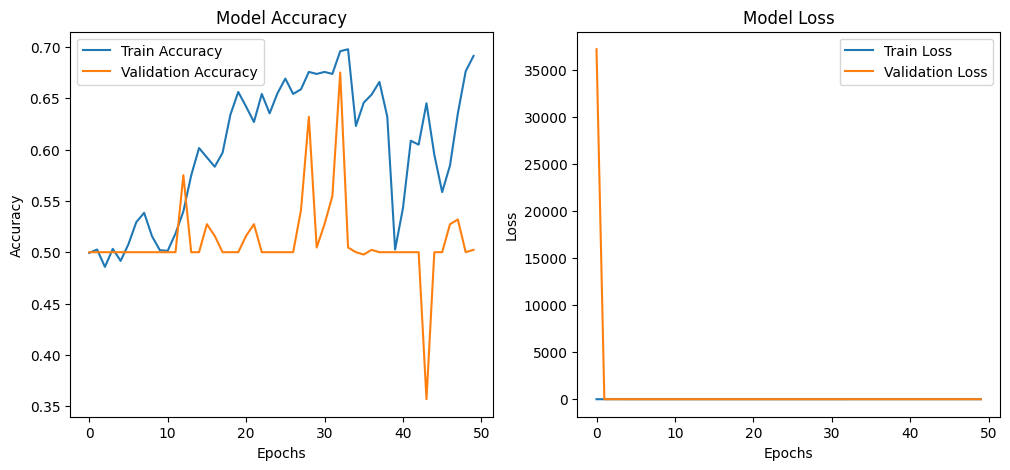

In [28]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [29]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_NoFreeze_0.01.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.7610 - loss: 1.2374
Test Accuracy : 62.61%
Test Loss     : 1.257


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step


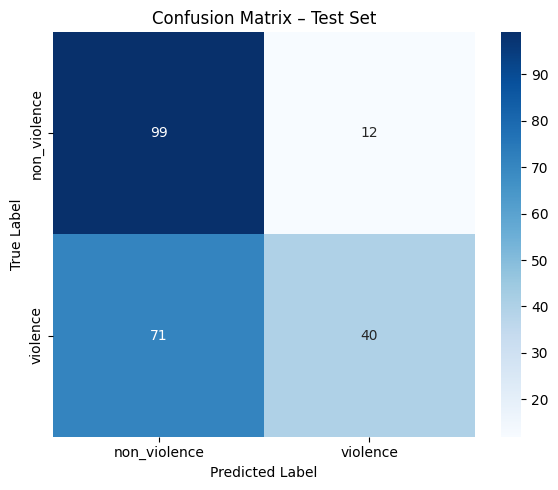


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.58      0.89      0.70       111
    violence       0.77      0.36      0.49       111

    accuracy                           0.63       222
   macro avg       0.68      0.63      0.60       222
weighted avg       0.68      0.63      0.60       222



In [30]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))